Custom notebook I did for the course "Fundamentals of Deep Reinforcement Learning" by LVx, as the original one is not available anymore on edX.

#PART 3 : Policy evaluation and iteration

In [1]:
import numpy as np

First, we're gonna implement the environement described in the video, which is a 4 by 4 cell grid, with two terminal states and a fixed transition reward of minus one.

![](./shemas_2.png)

In [2]:
class environment():
    def __init__(self):
        self.states = np.array([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]])
        self.transition_reward = -1

    def act(self, current_state, action):
        row, col = np.where(self.states == current_state)
        row = row[0]
        col = col[0]
        
        if action == "left":
            if col > 0:
                return self.states[row, col-1], self.transition_reward
            else:
                return current_state, self.transition_reward
            
        elif action == "right":
            if col < 3:
                    return self.states[row, col+1], self.transition_reward
            else:
                return current_state, self.transition_reward
            
        elif action == "up":
            if row > 0:
                return self.states[row-1, col], self.transition_reward
            else:
                return current_state, self.transition_reward
            
        elif action == "down":
            if row < 3:
                return self.states[row+1, col], self.transition_reward
            else:
                return current_state, self.transition_reward

    def is_terminal_state(self, state):
        if state == 0 or state == 15:
            return True
        else:
            return False
    
    def list_states(self):
        return self.states.flatten()

Now we can implement our agent (we can start with an agent that randomly choose either one of the four possible moves at each state)

In [3]:
class Agent():
    """a class that stores and update a policy. The policy is a 16 array with each cell being an inner array of size 4.
    Each inner array represent the probabilities of going respectively left, right, up and down for the given state in the outer array.
    Each outer array cell correspond to one state of the environement created above"""
    def __init__(self):
        self.policy = np.tile(np.array([[0.25, 0.25, 0.25, 0.25]]), (16, 1))
    
    def get_policy(self):
        return self.policy
    
    def update_policy(self, policy):
        self.policy = policy

Now, We will start by implementing the policy iteration algorithm (left), and after that we will implement the value iteration algorithm (right), so that we can compare performances.

![](./shemas_3.png)

Policy iteration

In [4]:
def Policy_eval(V, env, agent, gamma, theta):
    """evaluate the action value function V of a given policy using states and rewards from the environement, as well as the policy of the agent"""
    states = env.list_states()
    policy = agent.get_policy()
    
    while 1:
        delta = 0
        for state in range(len(states)):
            if env.is_terminal_state(state):
                continue
            
            v = V[state]

            cell_left, r_left = env.act(state, "left")
            cell_right, r_right = env.act(state, "right")
            cell_up, r_up = env.act(state, "up")
            cell_down, r_down = env.act(state, "down")

            V[state] = (
                policy[state][0] * (r_left + gamma * V[cell_left]) +
                policy[state][1] * (r_right + gamma * V[cell_right]) +
                policy[state][2] * (r_up + gamma * V[cell_up]) +
                policy[state][3] * (r_down + gamma * V[cell_down])
            )

            delta = max(delta, abs(v - V[state]))

        if delta < theta:
            break
    
    return V

In [5]:
def policy_improve(V, env, agent, gamma):
    states = env.list_states()
    policy = agent.get_policy()

    policy_stable = True

    for state in range(len(states)):
        if env.is_terminal_state(state):
            continue
        
        old_action = policy[state].copy()

        cell_left, r_left = env.act(state, "left")
        cell_right, r_right = env.act(state, "right")
        cell_up, r_up = env.act(state, "up")
        cell_down, r_down = env.act(state, "down")

        value_left = r_left + gamma * V[cell_left]
        value_right = r_right + gamma * V[cell_right]
        value_up = r_up + gamma * V[cell_up]
        value_down = r_down + gamma * V[cell_down]

        values = [value_left, value_right, value_up, value_down]
        max_value = np.max(values)
        max_indices = [i for i, v in enumerate(values) if v == max_value]
        policy_improved = np.zeros(len(values))
        for index in max_indices:
            policy_improved[index] = 1 / len(max_indices)
        
        policy[state] = policy_improved
        
        if not np.array_equal(old_action, policy_improved):
            policy_stable = False
    
    return policy_stable, policy

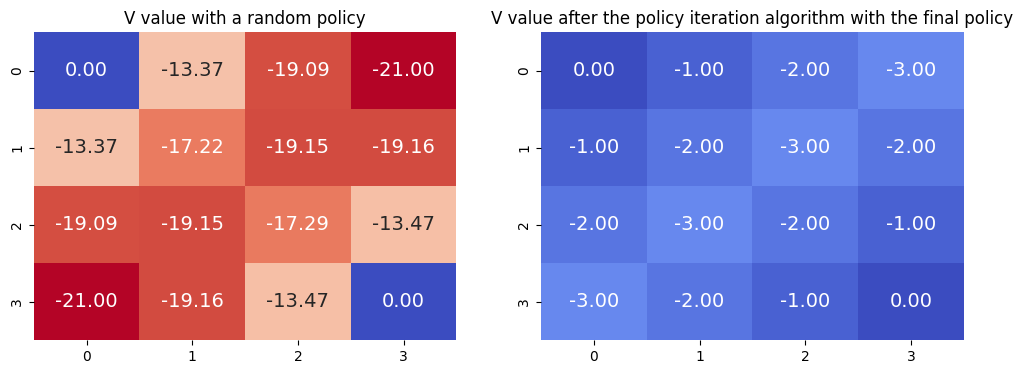

execution time :  0.017879247665405273


In [6]:
import time
import seaborn as sns
import matplotlib.pyplot as plt

V = np.zeros([16])

env = environment()
agent = Agent()
gamma = 1
theta = 0.1

policy_stable = False

first_iteration = True

# main loop
start_time = time.time()
while not policy_stable:

    V = Policy_eval(V, env, agent, gamma, theta)

    if first_iteration:
        V_matrix_random = V.reshape(4, 4).copy()
        first_iteration = False

    policy_stable, policy = policy_improve(V, env, agent, gamma)

    agent.update_policy(policy)

end_time = time.time()
execution_time = end_time - start_time

V_matrix = V.reshape(4, 4)


## Display
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(V_matrix_random, annot=True, cmap='coolwarm_r', fmt=".2f", cbar=False, annot_kws={"size": 14})
plt.title("V value with a random policy")

plt.subplot(1, 2, 2)
sns.heatmap(V_matrix, annot=True, cmap='coolwarm_r', fmt=".2f", cbar=False, annot_kws={"size": 14}, vmin=np.min(V_matrix_random), vmax=np.max(V_matrix_random))
plt.title("V value after the policy iteration algorithm with the final policy")

plt.show()

print("execution time : ", execution_time)

Now let's implement the second algorithm !

In [7]:
def Value_iteration(V, env, agent, gamma):
    states = env.list_states()
    policy = agent.get_policy()

    while 1:
        delta = 0
        for state in range(len(states)):
            if env.is_terminal_state(state):
                continue
            
            v = V[state]

            cell_left, r_left = env.act(state, "left")
            cell_right, r_right = env.act(state, "right")
            cell_up, r_up = env.act(state, "up")
            cell_down, r_down = env.act(state, "down")

            value_left = r_left + gamma * V[cell_left]
            value_right = r_right + gamma * V[cell_right]
            value_up = r_up + gamma * V[cell_up]
            value_down = r_down + gamma * V[cell_down]
            
            values = [value_left, value_down, value_right, value_up]
            value_max = max(values)
            ind = values.index(value_max)

            V[state] = value_max

            delta = max(delta, abs(v - V[state]))

            # let's update the policy right now
            policy[state] = [0] * 4
            policy[state][ind] = 1

        if delta < theta:
            break
    
    return V, policy

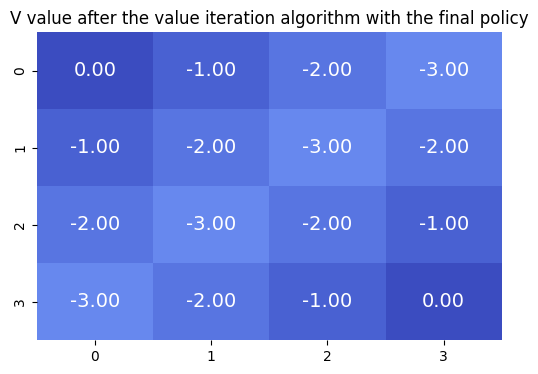

execution time :  0.0016107559204101562


In [8]:
import time
import seaborn as sns
import matplotlib.pyplot as plt

V = np.zeros([16])

env = environment()
agent = Agent()
gamma = 1
theta = 0.1

# main loop
start_time = time.time()

V, policy = Value_iteration(V, env, agent, gamma)

end_time = time.time()
execution_time_2 = end_time - start_time

V_matrix = V.reshape(4, 4)


## Display
plt.figure(figsize=(6, 4))

sns.heatmap(V_matrix, annot=True, cmap='coolwarm_r', fmt=".2f", cbar=False, annot_kws={"size": 14}, vmin=np.min(V_matrix_random), vmax=np.max(V_matrix_random))
plt.title("V value after the value iteration algorithm with the final policy")

plt.show()

print("execution time : ", execution_time_2)

In [9]:
t = execution_time / execution_time_2
print("the value iteration algorithm is {} time faster than the policy iteration algorithm".format(t))

# This is just an information to confirm what was said in the video, but it should not be treated too seriously / precisely as my algorithms are far from optimal

the value iteration algorithm is 11.099911190053286 time faster than the policy iteration algorithm
